In [1]:
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import os
from sklearn.ensemble import RandomForestClassifier
import skimage
from skimage import transform

In [14]:
# Define the Expected Value matrix values
values = np.array([[7000, -7730, -14300, -1440],
                   [-2800, -30, -1600, -4240],
                   [-8200, -4430, 4000, -13240],
                   [-10960, -25470, -25040, 21200]])

### Cluster

In [11]:
# Set the path to the dataset folder containing subfolders for each class
data_dir = 'Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Define image size
image_size = (125, 125)

# Define the order in which to process the classes
class_order = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Load dataset
def load_images_and_labels(data_dir, image_size):
    print("Loading images and labels...")
    images, labels = [], []
    for class_label, class_name in enumerate(class_order):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):  # Check if the file is a directory
            print("Processing images in directory:", class_dir)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                if os.path.isfile(image_path):  # Check if the file is an image file
                    image = load_img(image_path, target_size=image_size)
                    image_array = img_to_array(image) / 255.0
                    images.append(image_array)
                    labels.append(class_label)
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_dir, image_size)

Loading images and labels...
Processing images in directory: Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst
Processing images in directory: Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal
Processing images in directory: Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone
Processing images in directory: Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor


In [22]:
# Prepare the data for clustering and logistic regression
X = images.reshape(len(images), -1)
y = labels

# Cluster the data into 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
labels_pred = kmeans.fit_predict(X)

# Print the number of images in each cluster
unique_labels, counts = np.unique(labels_pred, return_counts=True)
for i in range(len(unique_labels)):
    print(f"Cluster {unique_labels[i]}: {counts[i]} images")

Cluster 0: 8209 images
Cluster 1: 4237 images


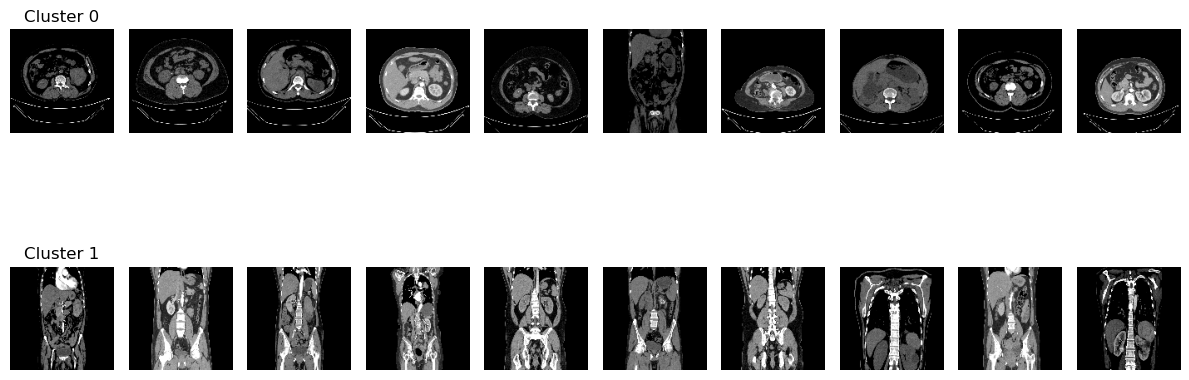

In [23]:
# Print 10 image samples for each cluster
num_samples = 10
fig, axs = plt.subplots(2, num_samples, figsize=(12, 6))
for i in range(2):
    cluster_indices = np.where(labels_pred == i)[0]
    sample_indices = np.random.choice(cluster_indices, num_samples, replace=False)
    for j, idx in enumerate(sample_indices):
        axs[i, j].imshow(images[idx])
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(f"Cluster {i}")
plt.tight_layout()
plt.show()

In [24]:
# Prepare the data for logistic regression for cluster 0
X_cluster0 = X[labels_pred == 0]
y_cluster0 = y[labels_pred == 0]

# Split the data into training and validation sets for cluster 0
X_val_cluster0, X_test_cluster0, y_val_cluster0, y_test_cluster0 = train_test_split(X_cluster0, y_cluster0, test_size=0.1, random_state=42)
X_train_cluster0, X_val_cluster0, y_train_cluster0, y_val_cluster0 = train_test_split(X_val_cluster0, y_val_cluster0, test_size=0.1, random_state=42)

### CNN

In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
import pandas as pd
from imblearn.over_sampling import SMOTE
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
print(X_train_cluster0.shape)

(6649, 46875)


In [29]:
# Apply SMOTE for oversampling on the training data only
smt = SMOTE()
num_samples_cluster0 = X_train_cluster0.shape[0]
X_train_oversampled_cluster0, y_train_oversampled_cluster0 = smt.fit_resample(X_train_cluster0.reshape(num_samples_cluster0, -1), y_train_cluster0)
X_train_oversampled_cluster0 = X_train_oversampled_cluster0.reshape(-1, 125, 125, 3).astype('float32')

In [33]:
# Build the model
model_cluster0 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(125, 125, 3), data_format="channels_last"),
    MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    Conv2D(64, (3, 3), activation='relu', data_format="channels_last"),
    MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    Conv2D(128, (3, 3), activation='relu', data_format="channels_last"),
    MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes in the dataset
])

# Compile the model
model_cluster0.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)

num_samples_val_cluster0 = X_val_cluster0.shape[0]
X_val_cluster0_reshaped = X_val_cluster0.reshape(num_samples_val_cluster0, 125, 125, 3).astype('float32')

history_cluster0 = model_cluster0.fit(X_train_oversampled_cluster0, y_train_oversampled_cluster0,
                    epochs=50,
                    validation_data=(X_val_cluster0_reshaped, y_val_cluster0),
                    callbacks=[early_stopping])

num_samples_test = X_test_cluster0.shape[0]
X_test_cluster0_reshaped = X_test_cluster0.reshape(-1, 125, 125, 3).astype('float32')

test_loss_cluster0, test_accuracy_cluster0 = model_cluster0.evaluate(X_test_cluster0_reshaped, y_test_cluster0)
print(f"Test loss: {test_loss_cluster0:.4f}")
print(f"Test accuracy: {test_accuracy_cluster0:.4f}")

# Make predictions on the test set
y_pred_cluster0 = model_cluster0.predict(X_test_cluster0_reshaped)
y_pred_cluster0 = np.argmax(y_pred_cluster0, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_cluster0, y_pred_cluster0)

# Print the confusion matrix
print(cm)

# Multiply the values matrix with the test confusion matrix
expected_cm_cluster0 = values * cm
print("Expected value matrix for cluster 0 test:")
print(expected_cm_cluster0)

# Sum the expected value matrix for cluster 1 test
sum_expected_cm_cluster0 = np.sum(expected_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_cm_cluster0)

Epoch 1/50


2023-04-20 20:15:49.536935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.9235

2023-04-20 20:15:57.343416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - 8s 24ms/step - loss: 0.1909 - accuracy: 0.9235 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 6.9569e-05 - val_accuracy: 1.0000
Epoch 3/50
334/334 [==============================] - 7s 22ms/step - loss: 6.0642e-05 - accuracy: 1.0000 - val_loss: 1.3879e-05 - val_accuracy: 1.0000
Epoch 4/50
334/334 [==============================] - 7s 22ms/step - loss: 5.6491e-05 - accuracy: 1.0000 - val_loss: 1.0951e-05 - val_accuracy: 1.0000
Epoch 5/50
334/334 [==============================] - 7s 22ms/step - loss: 1.0448e-05 - accuracy: 1.0000 - val_loss: 7.0155e-06 - val_accuracy: 1.0000
Epoch 6/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 1.0000
Test loss: 0.0013
Test accuracy: 1.0000
13/26 [==============>...............] - ETA: 0s

2023-04-20 20:16:35.099666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 0s 10ms/step
[[269   0   0   0]
 [  0 317   0   0]
 [  0   0  99   0]
 [  0   0   0 136]]
Expected value matrix for cluster 0 test:
[[1883000       0       0       0]
 [      0   -9510       0       0]
 [      0       0  396000       0]
 [      0       0       0 2883200]]
Sum of expected value matrix for cluster 0 test: 5152690


In [34]:
# Prepare the data for logistic regression for cluster 1
X_cluster1 = X[labels_pred == 1]
y_cluster1 = y[labels_pred == 1]

# Split the data into training and validation sets for cluster 1
X_val_cluster1, X_test_cluster1, y_val_cluster1, y_test_cluster1 = train_test_split(X_cluster1, y_cluster1, test_size=0.1, random_state=42)
X_train_cluster1, X_val_cluster1, y_train_cluster1, y_val_cluster1 = train_test_split(X_val_cluster1, y_val_cluster1, test_size=0.1, random_state=42)

# Apply SMOTE for oversampling on the training data only
smt = SMOTE()
num_samples_cluster1 = X_train_cluster1.shape[0]
X_train_oversampled_cluster1, y_train_oversampled_cluster1 = smt.fit_resample(X_train_cluster1.reshape(num_samples_cluster1, -1), y_train_cluster1)
X_train_oversampled_cluster1 = X_train_oversampled_cluster1.reshape(-1, 125, 125, 3).astype('float32')

In [35]:
# Build the model
model_cluster1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(125, 125, 3), data_format="channels_last"),
    MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    Conv2D(64, (3, 3), activation='relu', data_format="channels_last"),
    MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    Conv2D(128, (3, 3), activation='relu', data_format="channels_last"),
    MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes in the dataset
])

# Compile the model
model_cluster1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)

num_samples_val_cluster1 = X_val_cluster1.shape[0]
X_val_cluster1_reshaped = X_val_cluster1.reshape(num_samples_val_cluster1, 125, 125, 3).astype('float32')

history_cluster1 = model_cluster1.fit(X_train_oversampled_cluster1, y_train_oversampled_cluster1,
                    epochs=50,
                    validation_data=(X_val_cluster1_reshaped, y_val_cluster1),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
num_samples_test = X_test_cluster1.shape[0]
X_test_cluster1_reshaped = X_test_cluster1.reshape(-1, 125, 125, 3).astype('float32')

test_loss_cluster1, test_accuracy_cluster1 = model_cluster1.evaluate(X_test_cluster1_reshaped, y_test_cluster1)
print(f"Test loss: {test_loss_cluster1:.4f}")
print(f"Test accuracy: {test_accuracy_cluster1:.4f}")

# Make predictions on the test set
y_pred_cluster1 = model_cluster1.predict(X_test_cluster1_reshaped)
y_pred_cluster1 = np.argmax(y_pred_cluster1, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_cluster1, y_pred_cluster1)

# Print the confusion matrix
print(cm)

# Multiply the values matrix with the test confusion matrix
expected_cm_cluster1 = values * cm
print("Expected value matrix for cluster 1 test:")
print(expected_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_cm_cluster1 = np.sum(expected_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_cm_cluster1)

Epoch 1/50


2023-04-20 20:16:47.090866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


183/183 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8714

2023-04-20 20:16:51.495972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


183/183 [==============================] - 5s 25ms/step - loss: 0.3155 - accuracy: 0.8714 - val_loss: 0.0229 - val_accuracy: 0.9921
Epoch 2/50
183/183 [==============================] - 4s 22ms/step - loss: 0.0168 - accuracy: 0.9957 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/50
183/183 [==============================] - 4s 22ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0103 - val_accuracy: 0.9974
Epoch 4/50
183/183 [==============================] - 4s 22ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 5/50
183/183 [==============================] - 4s 22ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0341 - val_accuracy: 0.9791
Epoch 6/50
183/183 [==============================] - 4s 22ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 2.8142e-05 - val_accuracy: 1.0000
Epoch 7/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0010 - accuracy: 1.0000
Test loss: 0.0010
Test accuracy: 1.0000
14/14 [===

2023-04-20 20:17:16.224802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [38]:
def add_noise(image, noise_factor=0.1):
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0., 1.)

# Add noise to the test dataset
noisy_X_test_cluster0 = np.array([add_noise(img) for img in X_test_cluster0_reshaped])

# Make predictions on the noisy test dataset
noisy_y_pred_cluster0 = model_cluster0.predict(noisy_X_test_cluster0)
noisy_y_pred_labels_cluster0 = np.argmax(noisy_y_pred_cluster0, axis=1)

# Calculate accuracy on the noisy test dataset
noisy_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, noisy_y_pred_labels_cluster0)
print(f"Noisy test accuracy: {noisy_test_accuracy_cluster0:.4f}")

# confusion matrix on the noisy test dataset
noisy_cm_cluster0 = confusion_matrix(y_test_cluster0, noisy_y_pred_labels_cluster0)
print("Confusion matrix for noisy test dataset:")
print(noisy_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster0 = values * noisy_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_noisy_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_test_cm_cluster0 = np.sum(expected_noisy_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_noisy_test_cm_cluster0)

26/26 [==============================] - 1s 19ms/step
Noisy test accuracy: 1.0000
Confusion matrix for noisy test dataset:
[[269   0   0   0]
 [  0 317   0   0]
 [  0   0  99   0]
 [  0   0   0 136]]
Expected value matrix for cluster 0 test:
[[1883000       0       0       0]
 [      0   -9510       0       0]
 [      0       0  396000       0]
 [      0       0       0 2883200]]
Sum of expected value matrix for cluster 0 test: 5152690


In [39]:
def add_noise(image, noise_factor=0.1):
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0., 1.)

# Add noise to the test dataset
noisy_X_test_cluster1 = np.array([add_noise(img) for img in X_test_cluster1_reshaped])

# Make predictions on the noisy test dataset
noisy_y_pred_cluster1 = model_cluster1.predict(noisy_X_test_cluster1)
noisy_y_pred_labels_cluster1 = np.argmax(noisy_y_pred_cluster1, axis=1)

# Calculate accuracy on the noisy test dataset
noisy_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, noisy_y_pred_labels_cluster1)
print(f"Noisy test accuracy: {noisy_test_accuracy_cluster1:.4f}")

# confusion matrix on the noisy test dataset
noisy_cm_cluster1 = confusion_matrix(y_test_cluster1, noisy_y_pred_labels_cluster1)
print("Confusion matrix for noisy test dataset:")
print(noisy_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster1 = values * noisy_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_noisy_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_noisy_test_cm_cluster1 = np.sum(expected_noisy_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_noisy_test_cm_cluster1)

14/14 [==============================] - 0s 19ms/step
Noisy test accuracy: 0.9953
Confusion matrix for noisy test dataset:
[[114   0   2   0]
 [  0 184   0   0]
 [  0   0  48   0]
 [  0   0   0  76]]
Expected value matrix for cluster 1 test:
[[ 798000       0  -28600       0]
 [      0   -5520       0       0]
 [      0       0  192000       0]
 [      0       0       0 1611200]]
Sum of expected value matrix for cluster 1 test: 2567080


In [40]:
def rotate(image, angle):
    rotated_image = transform.rotate(image, angle)
    return rotated_image

# Reshape the images
#X_test_cluster0_re = X_test_cluster0.reshape(-1, 125, 125, 3)

# Define the rotation angle (degrees)
angle = 5

# Rotate the test images
rotate_X_test_cluster0 = np.array([rotate(img, angle=angle) for img in X_test_cluster0_reshaped])

# Make predictions on the rotated test dataset
rotate_y_pred_cluster0 = model_cluster0.predict(rotate_X_test_cluster0)
rotate_y_pred_labels_cluster0 = np.argmax(rotate_y_pred_cluster0, axis=1)

# Calculate accuracy on the rotated test dataset
rotate_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, rotate_y_pred_labels_cluster0)
print(f"Rotated test accuracy: {rotate_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the rotated test set
rotate_test_cm_cluster0 = confusion_matrix(y_test_cluster0, rotate_y_pred_labels_cluster0)
print("Confusion matrix for rotated test dataset:")
print(rotate_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster0 = values * rotate_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_noisy_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_test_cm_cluster0 = np.sum(expected_noisy_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_noisy_test_cm_cluster0)

26/26 [==============================] - 0s 17ms/step
Rotated test accuracy: 0.9367
Confusion matrix for rotated test dataset:
[[268   0   1   0]
 [  0 313   4   0]
 [  2   2  95   0]
 [ 12  22   9  93]]
Expected value matrix for cluster 0 test:
[[1876000       0  -14300       0]
 [      0   -9390   -6400       0]
 [ -16400   -8860  380000       0]
 [-131520 -560340 -225360 1971600]]
Sum of expected value matrix for cluster 0 test: 3255030


In [41]:
def rotate(image, angle):
    rotated_image = transform.rotate(image, angle)
    return rotated_image

# Reshape the images
#X_test_cluster1_re = X_test_cluster1.reshape(-1, 125, 125, 3)

# Define the rotation angle (degrees)
angle = 5

# Rotate the test images
rotate_X_test_cluster1 = np.array([rotate(img, angle=angle) for img in X_test_cluster1_reshaped])

# Make predictions on the rotated test dataset
rotate_y_pred_cluster1 = model_cluster1.predict(rotate_X_test_cluster1)
rotate_y_pred_labels_cluster1 = np.argmax(rotate_y_pred_cluster1, axis=1)

# Calculate accuracy on the rotated test dataset
rotate_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, rotate_y_pred_labels_cluster1)
print(f"Rotated test accuracy: {rotate_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the rotated test set
rotate_test_cm_cluster1 = confusion_matrix(y_test_cluster1, rotate_y_pred_labels_cluster1)
print("Confusion matrix for rotated test dataset:")
print(rotate_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster1 = values * rotate_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_noisy_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_noisy_test_cm_cluster1 = np.sum(expected_noisy_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_noisy_test_cm_cluster1)

14/14 [==============================] - 0s 19ms/step
Rotated test accuracy: 0.9316
Confusion matrix for rotated test dataset:
[[108   4   0   4]
 [  0 183   0   1]
 [  8   3  32   5]
 [  0   4   0  72]]
Expected value matrix for cluster 1 test:
[[ 756000  -30920       0   -5760]
 [      0   -5490       0   -4240]
 [ -65600  -13290  128000  -66200]
 [      0 -101880       0 1526400]]
Sum of expected value matrix for cluster 1 test: 2117020


In [42]:
def add_noise_and_rotate(image, noise_factor=0.1, angle=5):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
noisy_rotated_X_test_cluster0 = np.array([add_noise_and_rotate(img) for img in X_test_cluster0_reshaped])

# Make predictions on the noisy and rotated test dataset
noisy_rotated_y_pred_cluster0 = model_cluster0.predict(noisy_rotated_X_test_cluster0)
noisy_rotated_y_pred_labels_cluster0 = np.argmax(noisy_rotated_y_pred_cluster0, axis=1)

# Calculate accuracy on the noisy and rotated test dataset
noisy_rotated_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, noisy_rotated_y_pred_labels_cluster0)
print(f"Noisy and rotated test accuracy: {noisy_rotated_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
noisy_rotated_test_cm_cluster0 = confusion_matrix(y_test_cluster0, noisy_rotated_y_pred_labels_cluster0)
print("Confusion matrix for noisy and rotated test dataset:")
print(noisy_rotated_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster0 = values * noisy_rotated_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_noisy_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_test_cm_cluster0 = np.sum(expected_noisy_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_noisy_test_cm_cluster0)

26/26 [==============================] - 0s 18ms/step
Noisy and rotated test accuracy: 0.9452
Confusion matrix for noisy and rotated test dataset:
[[261   2   5   1]
 [  0 313   4   0]
 [  2   2  95   0]
 [  8  18   3 107]]
Expected value matrix for cluster 0 test:
[[1827000  -15460  -71500   -1440]
 [      0   -9390   -6400       0]
 [ -16400   -8860  380000       0]
 [ -87680 -458460  -75120 2268400]]
Sum of expected value matrix for cluster 0 test: 3724690


In [43]:
def add_noise_and_rotate(image, noise_factor=0.1, angle=5):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
noisy_rotated_X_test_cluster1 = np.array([add_noise_and_rotate(img) for img in X_test_cluster1_reshaped])

# Make predictions on the noisy and rotated test dataset
noisy_rotated_y_pred_cluster1 = model_cluster1.predict(noisy_rotated_X_test_cluster1)
noisy_rotated_y_pred_labels_cluster1 = np.argmax(noisy_rotated_y_pred_cluster1, axis=1)

# Calculate accuracy on the noisy and rotated test dataset
noisy_rotated_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, noisy_rotated_y_pred_labels_cluster1)
print(f"Noisy and rotated test accuracy: {noisy_rotated_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
noisy_rotated_test_cm_cluster1 = confusion_matrix(y_test_cluster1, noisy_rotated_y_pred_labels_cluster1)
print("Confusion matrix for noisy and rotated test dataset:")
print(noisy_rotated_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster1 = values * noisy_rotated_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_noisy_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_noisy_test_cm_cluster1 = np.sum(expected_noisy_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_noisy_test_cm_cluster1)

14/14 [==============================] - 0s 19ms/step
Noisy and rotated test accuracy: 0.9387
Confusion matrix for noisy and rotated test dataset:
[[111   4   0   1]
 [  0 181   0   3]
 [  8   3  34   3]
 [  0   4   0  72]]
Expected value matrix for cluster 1 test:
[[ 777000  -30920       0   -1440]
 [      0   -5430       0  -12720]
 [ -65600  -13290  136000  -39720]
 [      0 -101880       0 1526400]]
Sum of expected value matrix for cluster 1 test: 2168400


In [44]:
def add_noise_and_rotate(image, noise_factor=0.5, angle=15):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
noisy_rotated_X_test_cluster0 = np.array([add_noise_and_rotate(img) for img in X_test_cluster0_reshaped])

# Make predictions on the noisy and rotated test dataset
noisy_rotated_y_pred_cluster0 = model_cluster0.predict(noisy_rotated_X_test_cluster0)
noisy_rotated_y_pred_labels_cluster0 = np.argmax(noisy_rotated_y_pred_cluster0, axis=1)

# Calculate accuracy on the noisy and rotated test dataset
noisy_rotated_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, noisy_rotated_y_pred_labels_cluster0)
print(f"Noisy and rotated test accuracy: {noisy_rotated_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
noisy_rotated_test_cm_cluster0 = confusion_matrix(y_test_cluster0, noisy_rotated_y_pred_labels_cluster0)
print("Confusion matrix for noisy and rotated test dataset:")
print(noisy_rotated_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster0 = values * noisy_rotated_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_noisy_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_test_cm_cluster0 = np.sum(expected_noisy_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_noisy_test_cm_cluster0)

26/26 [==============================] - 0s 17ms/step
Noisy and rotated test accuracy: 0.6382
Confusion matrix for noisy and rotated test dataset:
[[194  31  41   3]
 [  7 300   6   4]
 [ 29  47  22   1]
 [ 21 103   4   8]]
Expected value matrix for cluster 0 test:
[[ 1358000  -239630  -586300    -4320]
 [  -19600    -9000    -9600   -16960]
 [ -237800  -208210    88000   -13240]
 [ -230160 -2623410  -100160   169600]]
Sum of expected value matrix for cluster 0 test: -2682790


In [45]:
def add_noise_and_rotate(image, noise_factor=0.5, angle=15):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
noisy_rotated_X_test_cluster1 = np.array([add_noise_and_rotate(img) for img in X_test_cluster1_reshaped])

# Make predictions on the noisy and rotated test dataset
noisy_rotated_y_pred_cluster1 = model_cluster1.predict(noisy_rotated_X_test_cluster1)
noisy_rotated_y_pred_labels_cluster1 = np.argmax(noisy_rotated_y_pred_cluster1, axis=1)

# Calculate accuracy on the noisy and rotated test dataset
noisy_rotated_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, noisy_rotated_y_pred_labels_cluster1)
print(f"Noisy and rotated test accuracy: {noisy_rotated_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
noisy_rotated_test_cm_cluster1 = confusion_matrix(y_test_cluster1, noisy_rotated_y_pred_labels_cluster1)
print("Confusion matrix for noisy and rotated test dataset:")
print(noisy_rotated_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster1 = values * noisy_rotated_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_noisy_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_noisy_test_cm_cluster1 = np.sum(expected_noisy_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_noisy_test_cm_cluster1)

14/14 [==============================] - 0s 17ms/step
Noisy and rotated test accuracy: 0.5236
Confusion matrix for noisy and rotated test dataset:
[[ 37  74   5   0]
 [  0 184   0   0]
 [  0  47   1   0]
 [  4  71   1   0]]
Expected value matrix for cluster 1 test:
[[  259000  -572020   -71500        0]
 [       0    -5520        0        0]
 [       0  -208210     4000        0]
 [  -43840 -1808370   -25040        0]]
Sum of expected value matrix for cluster 1 test: -2471500
